# Library

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn

import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

# Load dataset

In [33]:
# Transform image to 1x784 and normalize colors
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True)

# Preliminary computation

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])


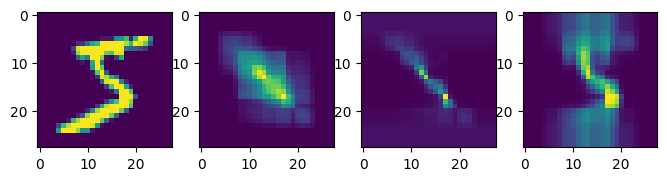

In [25]:
img, label = trainset[0]
input_size = img.shape[1:]

Q = img.clone()
K = img.clone()
V = img.clone()

soft_max = nn.Softmax(dim=2)

QT = torch.transpose(Q, 1, 2)

qTk = torch.bmm(QT, K)
atten_weight = soft_max(qTk)

Att_pool = torch.bmm(atten_weight, V)

fig, ax = plt.subplots(figsize=(8,2), nrows=1, ncols=4)
plt.subplot(1,4,1)
plt.imshow(Q.squeeze(0))
plt.subplot(1,4,2)
plt.imshow(qTk.squeeze(0))
plt.subplot(1,4,3)
plt.imshow(atten_weight.squeeze(0))

plt.subplot(1,4,4)
plt.imshow(Att_pool.squeeze(0))
Att_pool = Att_pool.squeeze(0)
print(atten_weight.sum(dim=2))

# Model description

$$ \mathrm{Attention}(\mathbf{q},\mathbf{k},\mathbf{v}) = \sum_{i=1}^m{\alpha(\mathbf{q},\mathbf{k}_i) \mathbf{v}_i} $$

where $\mathbf{q}, \mathbf{k}, \mathbf{v} \in \mathbb{R}^d$.

Scaled dot product attention scoring function:

$$ a(\mathbf{q},\mathbf{k}_i) = \mathbf{q}^T \mathbf{k}_i / \sqrt{d} $$

Attention weights

$$ \alpha(\mathbf{q},\mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q},\mathbf{k}_i)) = \frac{\exp(\mathbf{q}^T \mathbf{k}_i / \sqrt{d})}{\sum_{j=1}\exp(\mathbf{q}^T \mathbf{k}_j / \sqrt{d})}$$

In [43]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    # def __init__(self, dropout):
    def __init__(self):
        super().__init__()
        # self.dropout = nn.Dropout(dropout)
        self.soft_max = nn.Softmax(dim=2)

    # Shape of queries: (batch_size, img-height, d)
    # Shape of keys: (batch_size, img-height, d)
    # Shape of values: (batch_size, img-height, value dimension)
    def forward(self, queries, keys, values):
        d = queries.shape[2]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / np.sqrt(d)
        self.attention_weights = self.soft_max(scores)
        # return torch.bmm(self.dropout(self.attention_weights), values)
        return torch.bmm(self.attention_weights, values)

class sa_NN(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(sa_NN, self).__init__()
        d_model = input_size
        self.W_q = nn.Linear(input_size, d_model, device=device)
        self.W_k = nn.Linear(input_size, d_model, device=device)
        self.W_v = nn.Linear(input_size, d_model, device=device)
        self.W_o = nn.Linear(input_size*input_size, num_classes, device=device)
        
        self.num_classes = num_classes
        
        self.SDPA = DotProductAttention()

        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.W_o.weight)

    def forward(self, x):
        # Multiply input by weights and add biases
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        out = self.SDPA(Q, K, V)
        out = out.reshape(out.shape[0],-1)
        out = nn.functional.softmax(self.W_o(out),dim=0)
        
        return out

# Train loop

sa_NN(
  (W_q): Linear(in_features=28, out_features=28, bias=True)
  (W_k): Linear(in_features=28, out_features=28, bias=True)
  (W_v): Linear(in_features=28, out_features=28, bias=True)
  (W_o): Linear(in_features=784, out_features=10, bias=True)
  (SDPA): DotProductAttention(
    (soft_max): Softmax(dim=2)
  )
)
Epoch 1 - Training loss: 2.30216765999794
Epoch 2 - Training loss: 2.3014010965824125
Epoch 3 - Training loss: 2.3002675008773803
Epoch 4 - Training loss: 2.298559977610906
Epoch 5 - Training loss: 2.2963872110843657
Epoch 6 - Training loss: 2.2944070144494373
Epoch 7 - Training loss: 2.2929307536284127
Epoch 8 - Training loss: 2.2916798917452494
Epoch 9 - Training loss: 2.290489510297775
Epoch 10 - Training loss: 2.289341917435328

Training Time (in minutes) = 1.642786689599355


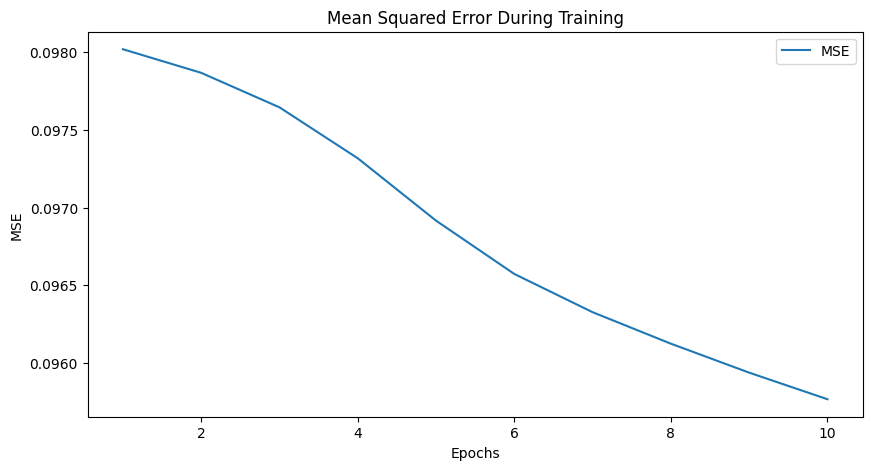

In [ ]:
# Build the Neural Network
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

model = sa_NN(input_size,output_size)
print(model)

criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss which includes softmax
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# Track MSE and loss
mse_list = []
loss_list = []

# Training the network
epochs = 10
time0 = time()

for e in range(epochs):
    running_loss = 0
    mse_loss = 0
    for images, labels in trainloader:
        # images = images.view(images.shape[0], -1)
        images = images.squeeze(1) 
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # Calculate MSE
        with torch.no_grad():
            mse_loss += torch.mean((output - nn.functional.one_hot(labels, num_classes=10).float())**2).item()
        
        # This is where the model learns by back propagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    
    loss_list.append(running_loss / len(trainloader))
    mse_list.append(mse_loss / len(trainloader))
    print(f"Epoch {e+1} - Training loss: {running_loss/len(trainloader)}")
    
print(f"\nTraining Time (in minutes) = {(time()-time0)/60}")

# Convert lists to numpy arrays
loss_array = np.array(loss_list)
mse_array = np.array(mse_list)

# Save arrays to .npy files
# np.save('loss_values.npy', loss_array)
# np.save('mse_values.npy', mse_array)

# Save the model
# torch.save(model.state_dict(), 'for_presentation.pth')

# Plot MSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), mse_list, label='MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Mean Squared Error During Training')
plt.legend()
plt.show()